See environment_setup.README (below) for instructions about the use of the DC3_plots_NALMA script. It is a version of the script used to process the DC3 dataset as in Barth et al. (2015, BAMS) and Bruning and Thomas (2015, JGR).

The flash sorting infrastructure is modular. This script uses the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN">DBSCAN algorithm </a> as implemented in the <a href="http://scikit-learn.org">scikit-learn</a> machine-learning library. In order to manage the $N^2$ efficiency of the underlying DBSCAN implementation, data are clustered in pairs of `thresh_duration` chunks.

The script is configurable in a few places. 
- `base_sort_dir` sets the path where 
- `center_ID` chooses a network center. The centers are defined in the `centers` dictionary. The ID is used later when constructing output filenames, too.
- The `params` dictionary configures the flash sorting algorithm. Of particular importance are the following.
  - `stations`: sets the (min, max) number of stations that must participate in each solution for it to count. Max should be larger than the number of stations. Min should be six or seven, depending on the number of stations.
  - `chi2`: sets the (min, max) chi-squared value. The minimum should be zero, while a good maximum to start with is 1.0.
  - `distance`: maximum distance between a source and its closest neighbor before a new flash is started
  - `thresh_critical_time`: maximum temporal separation between a source and its closest neighbor before a new flash is started
  - `thresh_duration`: All flashes should be last less than or equal to this number of seconds. All flashes of duration < `thresh_duration` are guaranteed to remain clustered. An occasional lucky flash of duration =  2 \* `thresh_duration` is possible.

The script is broken into three sections.
- Run the flash sorting, which creates HDF5 data files with VHF source data, their flash IDs, and a matching flash data table.
- Grab the flash-sorted files and create CF-compliant NetCDF grids
- Grab the grids and create PDF images of each grid

The grid spacing, boundaries, and frame intervals are configured at the begining of the gridding section of the script. This script creates regularly-spaced lat/lon grids, with the center grid cell size calculated to match the specified `dx_km` and `dy_km`. It is also possible to grid directly in a map projection of choice by changing `proj_name`, as well as `x_name` and `y_name` in the call to `make_plot`. For instance, a geostationary projection can be obtained with `proj='geos'` as described in the [documentation for the proj4 coordinate system library](http://trac.osgeo.org/proj/wiki/proj%3Dgeos).

The PDF images are created as small-multiple plots, with the number of columns given by `n_cols` at the beginning of the plotting section.

An example of reading and working with the resulting data files is found in the "Reading the flash-sorted files.ipynb"

As described below, additional scripts perform follow-on analysis.
- Assigning NLDN strokes to the best-matching flash
- Using a storm cell or storm region polygon to subset some flashes from the data files.
    - Creating time series plots of moments of the flash size distribution
    - Creating ASCII files of flash size and rate statistics


The IOP bounding box file included here is a rectangular lat/lon box, but the underlying code works with arbitrary polygons. Adapting the existing code to polygons is mostly a matter of reading in polygon vertices and sending its vertices instead of those for a rectangle.




In [3]:
%%bash

cat /data/GLM-wkshp/flashsort/environment_setup.README

8 September 2015 
Eric Bruning eric.bruning@ttu.edu

This document provides details about running a flash-sorting analysis, including
producing the flash time series statistics. These scripts are largely those used
for processing the DC3 dataset at TTU, and are suitable for (re)processing a large number of cases.

Python setup
------------

This analysis is run using the Anaconda Python distribution, with the primary
needs being numpy, scipy, matplotlib, pupynere, and pyproj.

After installing anaconda to your home directory, go to your home directory,
without anaconda already in $PATH

./anaconda/bin/conda create -n LMA --clone root

cd anaconda/envs/LMA/ source ./anaconda/bin/activate LMA

This sets up an environment with a python environment with just the necessary pieces for this LMA analysis.

then pip install git+http://github.com/deeplycloudy/lmatools
git+http://github.com/deeplycloudy/stormdrain

If you have to pause and return later then simply cd home and

source ./anaconda/b

In [12]:
# Links to representative PDFs.
from IPython.display import display, HTML, Image
class PDF(object):
    def __init__(self, filename):
        self.filename = filename

    def _repr_pdf_(self):
        return open(self.filename, 'rb').read()

In [16]:
base_path = '/data/GLM-wkshp/flashsort/figures-length/IOPsupercell18-AL-20090410-boundingbox-thresh-0.15_dist-3000.0_pts-10/'


## Case-specific time series data

** Locations of all flashes contributing to the analyses **

Lets you identify that only one cell was tracked

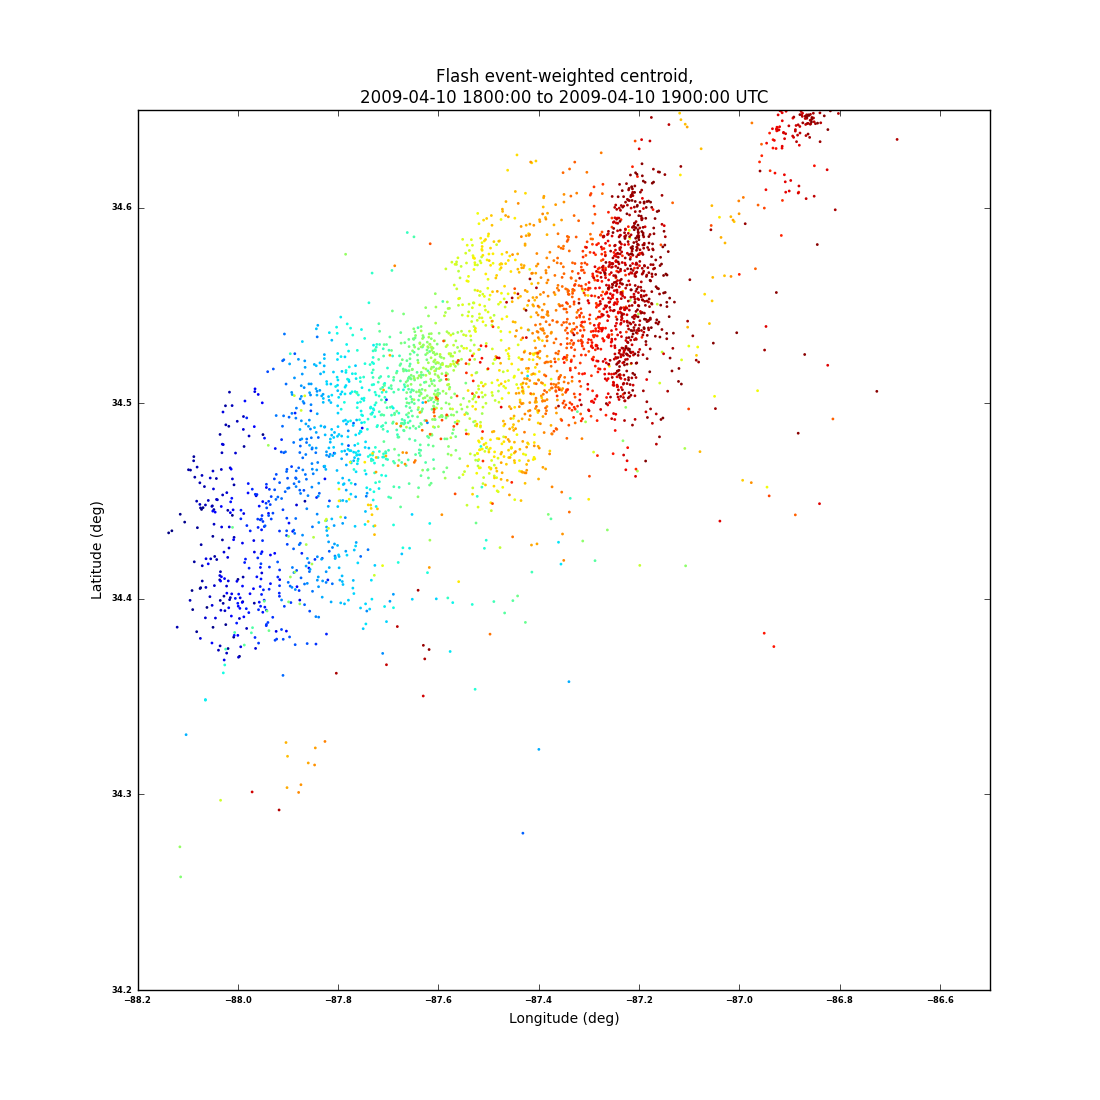

In [18]:
Image(base_path+'flashes.png')

**Time-height plot, separated by IC and CG.**

There are accompanying ASCII data files with the raw data. Uses the technique in Bruning and Thomas (2015, JGR)

In [10]:
PDF(base_path+'D-1.7_b-0.25_length-profiles_CG.pdf')

In [11]:
PDF(base_path+'D-1.7_b-0.25_length-profiles_IC.pdf')

**Time series of flash moments **

There are accompanying ASCII data files with the raw data. Uses the technique in Bruning and Thomas (2015, JGR).

In [24]:
PDF(base_path+'moment-energy-timeseries.pdf')

In [25]:
import pandas as pd
pd.read_csv(base_path+'../IOPsupercell18-output.flash_stats.csv')


,start_isoformat,end_isoformat,number,mean,variance,skewness,kurtosis,energy,energy/number
0,2009-04-10T18:00:00,2009-04-10T18:01:00,19,5.778776,19.602975,0.847279,-0.977476,1006.947327,52.997228
1,2009-04-10T18:01:00,2009-04-10T18:02:00,21,3.732302,4.780171,1.495719,1.565106,392.915283,18.710252
2,2009-04-10T18:02:00,2009-04-10T18:03:00,26,4.070445,5.901269,2.002315,3.638201,584.214661,22.469795
3,2009-04-10T18:03:00,2009-04-10T18:04:00,25,3.737550,8.718759,2.769132,8.407045,567.200989,22.688040
4,2009-04-10T18:04:00,2009-04-10T18:05:00,22,4.383382,12.730396,2.383367,5.815393,702.777527,31.944433
5,2009-04-10T18:05:00,2009-04-10T18:06:00,19,4.886418,8.262498,1.022592,-0.128251,610.651917,32.139575
6,2009-04-10T18:06:00,2009-04-10T18:07:00,19,5.011994,12.603062,2.047743,5.020269,716.739807,37.723148
7,2009-04-10T18:07:00,2009-04-10T18:08:00,15,4.261480,2.880228,0.124338,-0.928883,315.606598,21.040440
8,2009-04-10T18:08:00,2009-04-10T18:09:00,28,4.725330,11.574020,1.693249,2.865010,949.277344,33.902762
9,2009-04-10T18:09:00,2009-04-10T18:10:00,26,4.236659,6.982160,1.024067,-0.114266,648.217529,24.931443


** Plots of each minute in the gridded data **

LMA source density, flash extent density, flash initation density, and average flash area.

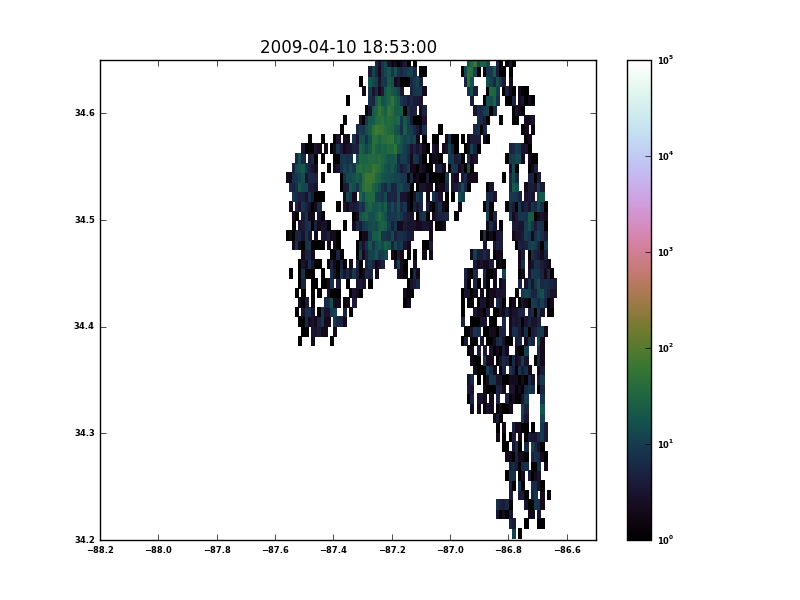

In [23]:
Image(base_path+'/grids_lma_source/lma_source_20090410_185300.png')

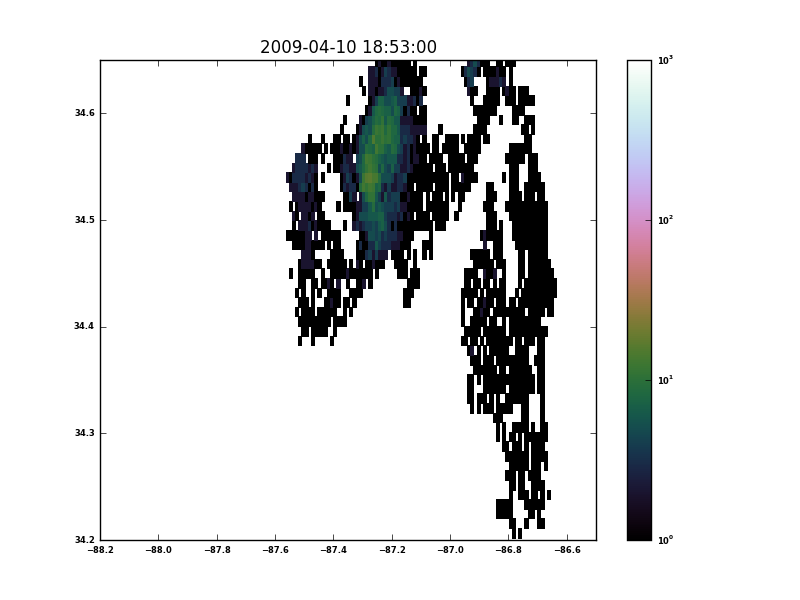

In [20]:
Image(base_path+'/grids_flash_extent/flash_extent_20090410_185300.png')

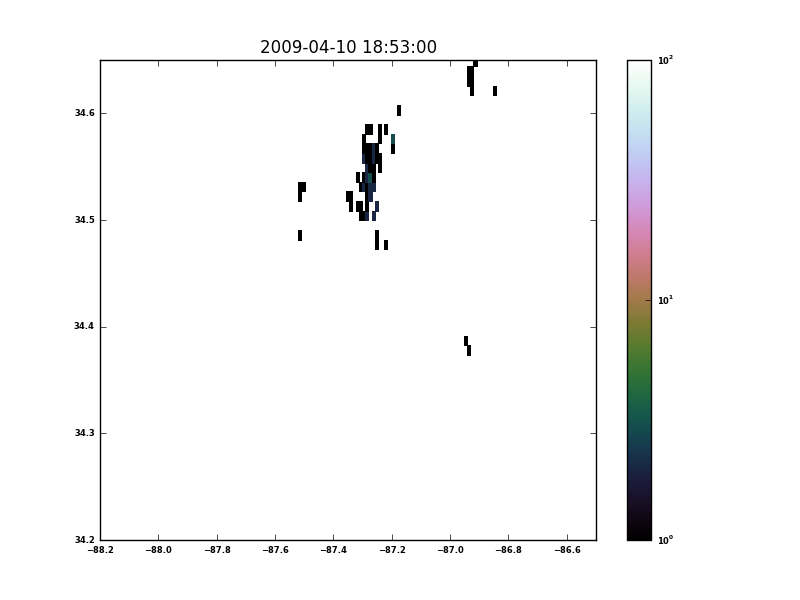

In [21]:
Image(base_path+'/grids_flash_initiation/flash_initiation_20090410_185300.png')

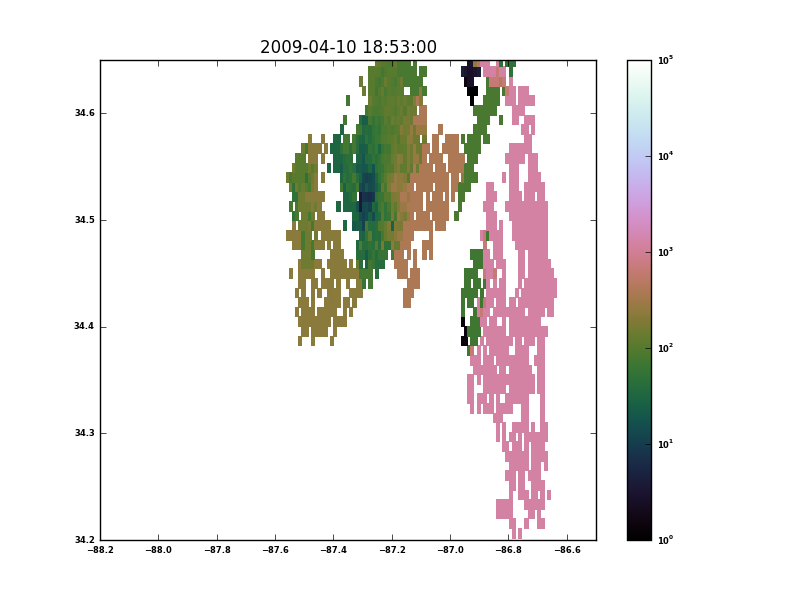

In [22]:
Image(base_path+'/grids_flash_footprint/flash_footprint_20090410_185300.png')

Each of the grid type folders contains a CSV file with statistics of the pixels making up the image.

In [29]:
pd.read_csv(base_path+'/grids_flash_extent/flash_extent_20090410.csv')

,time (ISO),max count per grid box,sum of all grid boxes,5th percentile,50th percentile,95th percentile
0,2009-04-10T18:00:00,5,641,1,1,3.0
1,2009-04-10T18:01:00,5,322,1,1,3.0
2,2009-04-10T18:02:00,7,513,1,1,4.0
3,2009-04-10T18:03:00,7,457,1,1,4.0
4,2009-04-10T18:04:00,5,580,1,1,3.0
5,2009-04-10T18:05:00,5,460,1,1,3.0
6,2009-04-10T18:06:00,5,430,1,1,3.0
7,2009-04-10T18:07:00,5,302,1,1,3.0
8,2009-04-10T18:08:00,7,631,1,1,4.0
9,2009-04-10T18:09:00,8,488,1,1,4.0


** Flash energy spectra **

Plots of the flash energy spectra as defined in Bruning and MacGorman (2013, JAS). A 5/3 power law reference line is plotted.

In [32]:
PDF(base_path+'LYLOUT_090410_180000_3600-energy.pdf')